In [1]:
from scipy.constants import c
from scipy.special import erf
import numpy as np
from numpy.lib import recfunctions as rec
from astropy.io          import fits
from astropy.coordinates import SkyCoord, Angle, search_around_sky
from astropy             import units as u
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
import pandas as pd
import math
from tqdm.notebook import tqdm
from scipy.optimize import minimize
import emcee
import iminuit
from iminuit import Minuit

Some function definitions:

* the model calls three different velocity dispersions, so it's cleaner to have a function for them
* the los distribution is a very cut-off gaussian, so renormalizing with erf is necessary
* the log likelihood, using flat priors whose limits are defined in a long 'if' statement.

In [2]:
def calc_sigma_v(theta, zcen, richness):
    """
    Calculate sigma_v (the width of the gaussian in our model)
    according to our model. Dependent on all parameters, as
    well as central galaxy info."""
    lnsigma_p, alpha, beta, z_p, lambda_p = theta
    return np.exp(lnsigma_p)*((1+zcen)/(1+z_p))**beta*(richness/lambda_p)**alpha

In [3]:
def calculate_vmax(richness):
    """Calculate the absolute velocity cutoff for interlopers in m/s.
    Follows equation (7) in redMaPPer IV.
    Parameters
    ----------
    richness : float
        Cluster richness, i.e. estimated number of galaxies belonging
        to the cluster.
    Returns
    -------
    vmax : float
        Maximum velocity value as set forth in equation (7) of redMaPPer IV.
        Units: 100 km/s
    """
    vmax = 3e6 * (richness / 20.0) ** 0.45 /100000 # 100km/s
    return vmax  # m/s

In [4]:
def background_gaussian(velocity, richness, total_sigma):
    """
    This function is used for evaluation of the line of sight
    gaussian. Sure, all Gaussians will have some fraction
    outside the vmax cut we made, and we'd have to normalize
    for that effect, but that amount is negligible for the
    orbiting and infalling Gaussians. But for the background
    Gaussian, a significant amount is cut off by the vmax cut,
    so I use an erf to scale and account for that."""
    vmax = 3e6 * (richness / 20.0) ** 0.45 / 100000
    outside_cut = np.where(velocity > vmax)[0]
    assert len(outside_cut) == 0, "UH OH: VELOCITY DATA FED INTO MCMC IS OUTSIDE CUT"

    z = vmax*(0.5**0.5)/total_sigma
    area_inside = erf(z)
    assert (area_inside != 0).all(), "Problem with vmax/sigma: " + str(vmax[np.where(z==0)]) + str(total_sigma[np.where(z==0)])
    normalization = 1/area_inside
    gaussian = np.exp(-0.5*((velocity/total_sigma)**2))/(np.sqrt(2*np.pi)*total_sigma)
    return_arr = normalization * gaussian

    if len(outside_cut) > 0:
        print("UH OH: VELOCITY DATA FED INTO MCMC IS OUTSIDE CUT")
        return_arr[outside_cut] = 0

    return return_arr

In [5]:
def nlnlike3(parameters):
    
    global v,r,rich,zcen,sigma_obs
    a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r=parameters

    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations

    z_p = np.median(zcen)
    lambda_p = np.median(rich)

    r_edge = r_p*((1+zcen)/(1+z_p))**beta_r*(rich/lambda_p)**alpha_r

    f_good = b0 + b1*(r/r_edge-1)
    f_orb = np.zeros_like(r)

    lt_xt = np.where(r < r_edge)[0]
    f_good[lt_xt] = 1 + a1*r[lt_xt]/r_edge[lt_xt] + a2*((r[lt_xt]/r_edge[lt_xt])**2)
    f_orb[lt_xt] = c0 + c1*r[lt_xt]/r_edge[lt_xt] + c2*((r[lt_xt]/r_edge[lt_xt])**2)

    orb_sigmav = calc_sigma_v([lnsp_orb, alpha_orb, beta_orb, z_p, lambda_p], zcen, rich)/(1+k*r/r_edge)**0.5
    orb_sigmat = (orb_sigmav**2 + sigma_obs**2)**0.5
    orb_gaussian = np.exp(-0.5*((v/orb_sigmat)**2))/(np.sqrt(2*np.pi)*orb_sigmat)

    inf_sigmav = calc_sigma_v([lnsp_inf, alpha_inf, beta_inf, z_p, lambda_p], zcen, rich)
    inf_sigmat = (inf_sigmav**2 + sigma_obs**2)**0.5
    inf_gaussian = np.exp(-0.5*((v/inf_sigmat)**2))/(np.sqrt(2*np.pi)*inf_sigmat)

    los_sigmav = calc_sigma_v([lnsp_los, alpha_los, beta_los, z_p, lambda_p], zcen, rich)
    los_sigmat = (los_sigmav**2 + sigma_obs**2)**0.5
    los_gaussian = background_gaussian(v, rich, los_sigmat)

    if 0.05 < alpha_orb < 1 and 0.05 < alpha_inf < 1 and 0.05 < alpha_los < 1 and -2 < alpha_r < 2 and -2 < beta_orb < 2 and -2 < beta_inf < 2 and -2 < beta_los < 2 and -2 < beta_r < 2 and 1 < lnsp_orb < 10 and 1 < lnsp_inf < 10 and lnsp_los < 50 and a1 < 0 and 0.2 < b0 < 1 and b1 < 0 and 0 < c0 <= 1 and c1 < 0 and (f_good > 0).all() and (f_orb >= 0).all() and 1 < r_p < 5 and k > 0:
        lp=0
    else:
        lp=-1e100
        
    return -np.sum(np.log(f_good*(f_orb*orb_gaussian+(1-f_orb)*inf_gaussian)+(1-f_good)*los_gaussian))-lp

In [6]:
def lnlike3(parameters):
    return -nlnlike3(parameters)

This function samples the distribution and plots it. df is the catalog you wish to plot, minr and maxr define the bin, and num_resample should be around 1000 for a smooth curve

In [90]:
def plot_fit(df,params,minr,maxr,num_resample):
    z_p = np.median(df.zcen)
    lambda_p = np.median(df.rich)

    r_edge = r_p*((1+df.zcen)/(1+z_p))**beta_r*(df.rich/lambda_p)**alpha_r
    print("The mean value of R_edge is %.2f. (Should be roughly 1.8)" % np.mean(r_edge))
    print("The pivot richness is %.2f. (Should be roughly 32)" % lambda_p)
    print("The pivot redshift is %.2f. (Should be roughly 0.17)" % z_p)

    min_x = -6
    max_x = 6
    num_data_bin_edges = 30
    num_sim_bin_edges = 251

    a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, x_p, alpha_x, beta_x = params #unpacking parameters

    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations

    x_t = x_p*((1+df.zcen)/(1+z_p))**beta_x*(df.rich/lambda_p)**alpha_x

    #df2=df.loc[ (df.r/x_t>1.0) & (df.r/x_t <=1.5) ].copy()
    #df2=df2.reset_index()

    df2=df[ (df.r/x_t>minr) & (df.r/x_t <=maxr) ].copy()
    df2=df2.reset_index()
    print(len(df2))
    
    rich=df2.rich
    zcen=df2.zcen
    x=df2.r
    v=df2.v
    sigma_obs = df2.sigma_obs
    x_t = x_p*((1+zcen)/(1+z_p))**beta_x*(rich/lambda_p)**alpha_x

    #assuming all are outside x_t
    f_good = b0 + b1*(x/x_t-1)
    f_orb = np.zeros_like(x)
    #find those where x is less than x_t
    lt_xt = np.where(x/x_t < 1)[0]

    #properly reassign those that are actually inside
    f_good[lt_xt] = 1 + a1*x[lt_xt]/x_t[lt_xt] + a2*((x[lt_xt]/x_t[lt_xt])**2)
    f_orb[lt_xt] = c0 + c1*x[lt_xt]/x_t[lt_xt] + c2*((x[lt_xt]/x_t[lt_xt])**2)

    #This sigma_v is just used to scale the plot, so I use orbiting to ensure that nothing is outside edges
    sigma_v = calc_sigma_v([lnsp_orb, alpha_orb, beta_orb, z_p, lambda_p], zcen, rich)/((1+k*x/x_t)**0.5)
    normalized_v = v/sigma_v

    data_x_vals = np.linspace(min_x, max_x, num_data_bin_edges)
    data_bin_centers = (data_x_vals[:-1] + data_x_vals[1:])/2.
    #err_bars, data_bin_centers = get_err(data, z_p, lambda_p, params, data_x_vals)
    sim_x_vals = np.linspace(min_x, max_x, num_sim_bin_edges)

    all_orb = np.ones([num_resample, num_sim_bin_edges-1])
    all_inf = np.ones([num_resample, num_sim_bin_edges-1])
    all_los = np.ones([num_resample, num_sim_bin_edges-1])

    data_x_vals = np.linspace(min_x, max_x, num_data_bin_edges)
    data_bin_centers = (data_x_vals[:-1] + data_x_vals[1:])/2.
    data_bin_width = data_bin_centers[1] - data_bin_centers[0]

    print("Maximum normalized velocity %.2f. (Should be roughly 8)" % np.max(normalized_v))
    counts, bin_edges = np.histogram(normalized_v, data_x_vals)
    normalized_counts = counts / float(len(v)) / data_bin_width

    for i in tqdm(range(num_resample)):
        fraction = np.random.rand(len(x))
        orb = np.where(fraction < f_good * f_orb)[0]
        inf = np.where((f_good * f_orb <= fraction) & (fraction < f_good))[0]
        los = np.where(fraction >= f_good)[0]

        assert len(los) + len(orb) + len(inf) == len(x), "Uh-oh: check np.where assignment at beginning of sample"
        orb_sigmav = calc_sigma_v([lnsp_orb, alpha_orb, beta_orb, z_p, lambda_p], zcen[orb], rich[orb])/((1+k*x[orb]/x_t[orb])**0.5)
        orb_sigmat = (orb_sigmav**2 + sigma_obs[orb]**2)**0.5
        orb_v = np.random.normal(0, orb_sigmat)
        inf_sigmav = calc_sigma_v([lnsp_inf, alpha_inf, beta_inf, z_p, lambda_p], zcen[inf], rich[inf])
        inf_sigmat = (inf_sigmav**2 + sigma_obs[inf]**2)**0.5
        inf_v = np.random.normal(0, inf_sigmat)
        los_sigmav = calc_sigma_v([lnsp_los, alpha_los, beta_los, z_p, lambda_p], zcen[los], rich[los])
        los_sigmat = (los_sigmav**2 + sigma_obs[los]**2)**0.5
        los_v = np.random.normal(0, los_sigmat)

        vmax = calculate_vmax(rich)
        vmax_orb = vmax[orb]
        vmax_inf = vmax[inf]
        vmax_los = vmax[los]
        illegal_orb = np.where(np.abs(orb_v) > vmax_orb)[0]
        illegal_inf = np.where(np.abs(inf_v) > vmax_inf)[0]
        illegal_los = np.where(np.abs(los_v) > vmax_los)[0]
        while len(illegal_orb) > 0:
            orb_sigmav = calc_sigma_v([lnsp_orb, alpha_orb, beta_orb, z_p, lambda_p], zcen[orb][illegal_orb], rich[orb][illegal_orb])/(1+k*x[orb][illegal_orb]/x_t[orb][illegal_orb])**0.5
            orb_sigmat = (orb_sigmav**2 + sigma_obs[orb][illegal_orb]**2)**0.5
            orb_v[illegal_orb] = np.random.normal(0, orb_sigmat)
            illegal_orb = np.where(np.abs(orb_v) > vmax_orb)[0]
        while len(illegal_inf) > 0:
            inf_sigmav = calc_sigma_v([lnsp_inf, alpha_inf, beta_inf, z_p, lambda_p], zcen[inf][illegal_inf], rich[inf][illegal_inf])
            inf_sigmat = (inf_sigmav**2 + sigma_obs[inf][illegal_inf]**2)**0.5
            inf_v[illegal_inf] = np.random.normal(0, inf_sigmat)
            illegal_inf = np.where(np.abs(inf_v) > vmax_inf)[0]
        while len(illegal_los) > 0:
            los_sigmav = calc_sigma_v([lnsp_los, alpha_los, beta_los, z_p, lambda_p], zcen[los][illegal_los], rich[los][illegal_los])
            los_sigmat = (los_sigmav**2 + sigma_obs[los][illegal_los]**2)**0.5
            los_v[illegal_los] = np.random.normal(0, los_sigmat)
            illegal_los = np.where(np.abs(los_v) > vmax_los)[0]

        orb_v_by_sig_v = orb_v / sigma_v[orb]
        inf_v_by_sig_v = inf_v / sigma_v[inf]
        los_v_by_sig_v = los_v / sigma_v[los]

        all_orb[i], bin_edges = np.histogram(orb_v_by_sig_v, sim_x_vals)
        all_inf[i], bin_edges = np.histogram(inf_v_by_sig_v, sim_x_vals)
        all_los[i], bin_edges = np.histogram(los_v_by_sig_v, sim_x_vals)

    sim_bin_centers = (sim_x_vals[:-1] + sim_x_vals[1:])/2.
    sim_bin_width = sim_bin_centers[1] - sim_bin_centers[0]

    orb_averaged = np.mean(all_orb, axis=0)
    orb_normalized = orb_averaged / float(len(x)) / sim_bin_width

    inf_averaged = np.mean(all_inf, axis=0)
    inf_normalized = inf_averaged / float(len(x)) / sim_bin_width

    los_averaged = np.mean(all_los, axis=0)
    los_normalized = los_averaged / float(len(x)) / sim_bin_width

    fig, axes = plt.subplots(figsize=(10,7))
    orb_lines = axes.plot(sim_bin_centers, orb_normalized, linewidth=1, ls="dashdot")
    inf_lines = axes.plot(sim_bin_centers, inf_normalized, linewidth=1, ls="dotted")
    los_lines = axes.plot(sim_bin_centers, los_normalized, linewidth=1, ls="dashed")
    sum_lines = axes.plot(sim_bin_centers, orb_normalized + inf_normalized + los_normalized, linewidth=1)
    axes.errorbar(data_bin_centers,normalized_counts,yerr=np.sqrt(counts)/float(len(v)) / data_bin_width,fmt="ko",markersize=1.5,elinewidth=0.8,capsize=1.8)
    axes.set_ylim(0,0.5)
    axes.set_xlabel('$v$ / $\sigma_{v,orb}$')
    axes.set_ylabel('P($v$ / $\sigma_{v,orb})$')

In [102]:
def multi_fit(df,params,num_resample):
    
    z_p = np.median(df.zcen)
    lambda_p = np.median(df.rich)

    r_edge = r_p*((1+df.zcen)/(1+z_p))**beta_r*(df.rich/lambda_p)**alpha_r
    print("The mean value of R_edge is %.2f. (Should be roughly 1.8)" % np.mean(r_edge))
    print("The pivot richness is %.2f. (Should be roughly 32)" % lambda_p)
    print("The pivot redshift is %.2f. (Should be roughly 0.17)" % z_p)

    min_x = -6
    max_x = 6
    num_data_bin_edges = 30
    num_sim_bin_edges = 251

    a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, x_p, alpha_x, beta_x = params #unpacking parameters

    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations

    x_t = x_p*((1+df.zcen)/(1+z_p))**beta_x*(df.rich/lambda_p)**alpha_x

    #df2=df.loc[ (df.r/x_t>1.0) & (df.r/x_t <=1.5) ].copy()
    #df2=df2.reset_index()
    
    intervals=[1.0,1.5,2.0,2.5]
    
    for plt_idx in range(0,3):
        
        minr=intervals[plt_idx]
        maxr=intervals[plt_idx+1]
        print(minr,maxr)
        
        x_t = x_p*((1+df.zcen)/(1+z_p))**beta_x*(df.rich/lambda_p)**alpha_x
        
        df2=df[ (df.r/x_t>minr) & (df.r/x_t <=maxr) ].copy(deep=True)
        df2=df2.reset_index()
        print(len(df2))
        
        rich=df2.rich
        zcen=df2.zcen
        x=df2.r
        v=df2.v
        sigma_obs = df2.sigma_obs
        x_t = x_p*((1+zcen)/(1+z_p))**beta_x*(rich/lambda_p)**alpha_x

        #assuming all are outside x_t
        f_good = b0 + b1*(x/x_t-1)
        f_orb = np.zeros_like(x)
        #find those where x is less than x_t
        lt_xt = np.where(x/x_t < 1)[0]

        #properly reassign those that are actually inside
        f_good[lt_xt] = 1 + a1*x[lt_xt]/x_t[lt_xt] + a2*((x[lt_xt]/x_t[lt_xt])**2)
        f_orb[lt_xt] = c0 + c1*x[lt_xt]/x_t[lt_xt] + c2*((x[lt_xt]/x_t[lt_xt])**2)

        #This sigma_v is just used to scale the plot, so I use orbiting to ensure that nothing is outside edges
        sigma_v = calc_sigma_v([lnsp_orb, alpha_orb, beta_orb, z_p, lambda_p], zcen, rich)/((1+k*x/x_t)**0.5)
        normalized_v = v/sigma_v

        data_x_vals = np.linspace(min_x, max_x, num_data_bin_edges)
        data_bin_centers = (data_x_vals[:-1] + data_x_vals[1:])/2.
        #err_bars, data_bin_centers = get_err(data, z_p, lambda_p, params, data_x_vals)
        sim_x_vals = np.linspace(min_x, max_x, num_sim_bin_edges)

        all_orb = np.ones([num_resample, num_sim_bin_edges-1])
        all_inf = np.ones([num_resample, num_sim_bin_edges-1])
        all_los = np.ones([num_resample, num_sim_bin_edges-1])

        data_x_vals = np.linspace(min_x, max_x, num_data_bin_edges)
        data_bin_centers = (data_x_vals[:-1] + data_x_vals[1:])/2.
        data_bin_width = data_bin_centers[1] - data_bin_centers[0]

        print("Maximum normalized velocity %.2f. (Should be roughly 8)" % np.max(normalized_v))
        counts, bin_edges = np.histogram(normalized_v, data_x_vals)
        normalized_counts = counts / float(len(v)) / data_bin_width

        for i in tqdm(range(num_resample)):
            fraction = np.random.rand(len(x))
            orb = np.where(fraction < f_good * f_orb)[0]
            inf = np.where((f_good * f_orb <= fraction) & (fraction < f_good))[0]
            los = np.where(fraction >= f_good)[0]

            assert len(los) + len(orb) + len(inf) == len(x), "Uh-oh: check np.where assignment at beginning of sample"
            orb_sigmav = calc_sigma_v([lnsp_orb, alpha_orb, beta_orb, z_p, lambda_p], zcen[orb], rich[orb])/((1+k*x[orb]/x_t[orb])**0.5)
            orb_sigmat = (orb_sigmav**2 + sigma_obs[orb]**2)**0.5
            orb_v = np.random.normal(0, orb_sigmat)
            inf_sigmav = calc_sigma_v([lnsp_inf, alpha_inf, beta_inf, z_p, lambda_p], zcen[inf], rich[inf])
            inf_sigmat = (inf_sigmav**2 + sigma_obs[inf]**2)**0.5
            inf_v = np.random.normal(0, inf_sigmat)
            los_sigmav = calc_sigma_v([lnsp_los, alpha_los, beta_los, z_p, lambda_p], zcen[los], rich[los])
            los_sigmat = (los_sigmav**2 + sigma_obs[los]**2)**0.5
            los_v = np.random.normal(0, los_sigmat)

            
            vmax = calculate_vmax(rich)
            vmax_orb = vmax[orb]
            vmax_inf = vmax[inf]
            vmax_los = vmax[los]
            illegal_orb = np.where(np.abs(orb_v) > vmax_orb)[0]
            illegal_inf = np.where(np.abs(inf_v) > vmax_inf)[0]
            illegal_los = np.where(np.abs(los_v) > vmax_los)[0]
            while len(illegal_orb) > 0:
                orb_sigmav = calc_sigma_v([lnsp_orb, alpha_orb, beta_orb, z_p, lambda_p], zcen[orb][illegal_orb], rich[orb][illegal_orb])/(1+k*x[orb][illegal_orb]/x_t[orb][illegal_orb])**0.5
                orb_sigmat = (orb_sigmav**2 + sigma_obs[orb][illegal_orb]**2)**0.5
                orb_v[illegal_orb] = np.random.normal(0, orb_sigmat)
                illegal_orb = np.where(np.abs(orb_v) > vmax_orb)[0]
            while len(illegal_inf) > 0:
                inf_sigmav = calc_sigma_v([lnsp_inf, alpha_inf, beta_inf, z_p, lambda_p], zcen[inf][illegal_inf], rich[inf][illegal_inf])
                inf_sigmat = (inf_sigmav**2 + sigma_obs[inf][illegal_inf]**2)**0.5
                inf_v[illegal_inf] = np.random.normal(0, inf_sigmat)
                illegal_inf = np.where(np.abs(inf_v) > vmax_inf)[0]
            while len(illegal_los) > 0:
                los_sigmav = calc_sigma_v([lnsp_los, alpha_los, beta_los, z_p, lambda_p], zcen[los][illegal_los], rich[los][illegal_los])
                los_sigmat = (los_sigmav**2 + sigma_obs[los][illegal_los]**2)**0.5
                los_v[illegal_los] = np.random.normal(0, los_sigmat)
                illegal_los = np.where(np.abs(los_v) > vmax_los)[0]
                
            orb_v_by_sig_v = orb_v / sigma_v[orb]
            inf_v_by_sig_v = inf_v / sigma_v[inf]
            los_v_by_sig_v = los_v / sigma_v[los]

            all_orb[i], bin_edges = np.histogram(orb_v_by_sig_v, sim_x_vals)
            all_inf[i], bin_edges = np.histogram(inf_v_by_sig_v, sim_x_vals)
            all_los[i], bin_edges = np.histogram(los_v_by_sig_v, sim_x_vals)

        sim_bin_centers = (sim_x_vals[:-1] + sim_x_vals[1:])/2.
        sim_bin_width = sim_bin_centers[1] - sim_bin_centers[0]

        orb_averaged = np.mean(all_orb, axis=0)
        orb_normalized = orb_averaged / float(len(x)) / sim_bin_width

        inf_averaged = np.mean(all_inf, axis=0)
        inf_normalized = inf_averaged / float(len(x)) / sim_bin_width

        los_averaged = np.mean(all_los, axis=0)
        los_normalized = los_averaged / float(len(x)) / sim_bin_width

        fig, axes = plt.subplots(figsize=(10,7))
        orb_lines = axes.plot(sim_bin_centers, orb_normalized, linewidth=1, ls="dashdot")
        inf_lines = axes.plot(sim_bin_centers, inf_normalized, linewidth=1, ls="dotted")
        los_lines = axes.plot(sim_bin_centers, los_normalized, linewidth=1, ls="dashed")
        sum_lines = axes.plot(sim_bin_centers, orb_normalized + inf_normalized + los_normalized, linewidth=1)
        #plt.subplot(4, 2, plt_idx+1)
        axes.errorbar(data_bin_centers,normalized_counts,yerr=np.sqrt(counts)/float(len(v)) / data_bin_width,fmt="ko",markersize=1.5,elinewidth=0.8,capsize=1.8)
        axes.set_ylim(0,0.5)
        axes.set_xlabel('$v$ / $\sigma_{v,orb}$')
        axes.set_ylabel('P($v$ / $\sigma_{v,orb})$')

In [103]:
multi_fit(df,origin,100)

The mean value of R_edge is 1.84. (Should be roughly 1.8)
The pivot richness is 32.19. (Should be roughly 32)
The pivot redshift is 0.17. (Should be roughly 0.17)
1.0 1.5
19521
Maximum normalized velocity 7.50. (Should be roughly 8)


KeyError: "None of [Int64Index([2782], dtype='int64')] are in the [index]"

In [120]:
plot_fit(df,m.np_values(),1.03,1.04,100)

The mean value of R_edge is 1.84. (Should be roughly 1.8)
The pivot richness is 32.19. (Should be roughly 32)
The pivot redshift is 0.17. (Should be roughly 0.17)
384
Maximum normalized velocity 6.81. (Should be roughly 8)


KeyError: "None of [Int64Index([56], dtype='int64')] are in the [index]"

In [8]:
#Parameters from 'Clusters have Edges'
a1=-0.512
a2=-0.032
b1=-0.010
c1=-0.061
c2=-0.693

sp_orb=7.77
lnsp_orb=np.log(sp_orb)
alpha_orb=0.43
beta_orb=0.353

sp_inf=4.48
lnsp_inf=np.log(sp_inf)
alpha_inf=0.363
beta_inf=0.113

sp_los=38.73
lnsp_los=np.log(sp_los)
alpha_los=0.503
beta_los=-0.328

alpha_r=0.305
beta_r=-0.385
r_p=1.79
k=0.883

origin=[a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r]
origin=np.array(origin)

In [9]:
#Parameters that Paxton's mcmc is initialized with
origin2 = [-0.45, -0.08, -0.1, -0.5, -0.2, 2.14, 0.9, 0.5, -0.25, 1.59, 0.38, -0.7, 3.79, 0.5, -0.4, 2, 0, -0.5]
delta2 = [0.02, 0.003, 0.02, 0.04, 0.04, 0.06, 0.05, 0.015, 0.06, 0.06, 0.01, 0.04, 0.08, 0.03, 0.08, 0.1, 0.05, 0.08]


In [10]:
#Parameters from 'Clusters have Edges'
da1=0.3
da2=0.053
db1=0.1
dc1=0.180
dc2=0.4

dsp_orb=0.21
dlnsp_orb=-np.log(dsp_orb)
dalpha_orb=0.019
dbeta_orb=0.195

dsp_inf=0.06
dlnsp_inf=-np.log(dsp_inf)
dalpha_inf=0.363
dbeta_inf=0.180

dsp_los=1.16
dlnsp_los=np.log(dsp_los)
dalpha_los=0.066
dbeta_los=0.48

dalpha_r=0.034
dbeta_r=0.289
dr_p=0.12
dk=0.238

delta=[da1, da2, db1, dc1, dc2, dlnsp_orb, -dk, dalpha_orb, dbeta_orb, dlnsp_inf, dalpha_inf, dbeta_inf, dlnsp_los, dalpha_los, dbeta_los, dr_p, dalpha_r, dbeta_r]
delta=np.array(delta)

In [11]:
print("Paper model parameters")
print("a1 = %.3f" % a1,u"\u00B1", "%.3f" % da1)
print("a2 = %.3f" % a2,u"\u00B1", "%.3f" % da2)
print("b1 = %.3f" % b1,u"\u00B1", "%.3f" % db1)
print("c1 = %.3f" % c1,u"\u00B1", "%.3f" % dc1)
print("c2 = %.3f" % c2,u"\u00B1", "%.3f" % dc2)
print("sp_orb = %.3f" % np.exp(lnsp_orb),u"\u00B1", "%.3f" % dlnsp_orb)
print("sp_inf = %.3f" % np.exp(lnsp_inf),u"\u00B1", "%.3f" % dlnsp_inf,)
print("sp_los = %.3f" % np.exp(lnsp_los),u"\u00B1", "%.3f" % dlnsp_los)
print("alpha_orb = %.3f" % alpha_orb,u"\u00B1", "%.3f" % dalpha_orb)
print("alpha_inf = %.3f" % alpha_inf,u"\u00B1", "%.3f" % dalpha_inf)
print("alpha_los = %.3f" % alpha_los,u"\u00B1", "%.3f" % dalpha_los)
print("beta_orb = %.3f" % beta_orb,u"\u00B1", "%.3f" % dbeta_orb)
print("beta_inf = %.3f" % beta_inf,u"\u00B1", "%.3f" % dbeta_orb)
print("beta_los = %.3f" % beta_los,u"\u00B1", "%.3f" % dbeta_los)
print("alpha_r = %.3f" % alpha_r,u"\u00B1", "%.3f" % dalpha_r)
print("beta_r = %.3f" % beta_r,u"\u00B1", "%.3f" % dbeta_r)
print("r_p = %.3f" % r_p,u"\u00B1", "%.3f" % dr_p)

Paper model parameters
a1 = -0.512 ± 0.300
a2 = -0.032 ± 0.053
b1 = -0.010 ± 0.100
c1 = -0.061 ± 0.180
c2 = -0.693 ± 0.400
sp_orb = 7.770 ± 1.561
sp_inf = 4.480 ± 2.813
sp_los = 38.730 ± 0.148
alpha_orb = 0.430 ± 0.019
alpha_inf = 0.363 ± 0.363
alpha_los = 0.503 ± 0.066
beta_orb = 0.353 ± 0.195
beta_inf = 0.113 ± 0.195
beta_los = -0.328 ± 0.480
alpha_r = 0.305 ± 0.034
beta_r = -0.385 ± 0.289
r_p = 1.790 ± 0.120


The paper's catalog is 'last_catalog.npy' and its revised version is 'rerun_catalog.npy', which you can load here. Note [v]=100km / s

In [12]:
fname = "last_catalog.npy"
dt = np.load(fname)
pax=pd.DataFrame.from_records(dt.tolist(), columns=dt.dtype.names)
rich=pax.LAMBDA_CHISQ
zcen=pax.BCG_SPEC_Z
r=pax.R
x=pax.R/pax.R_LAMBDA
v=pax.Velocity / 100000 #100 km/s
ra=pax.MEM_RA
dec=pax.MEM_DEC
sigma_obs = c*((pax.ZMEM_ERR**2 + pax.ZCEN_ERR**2)**(0.5)) / 100000 #100 km/s
pax=pd.DataFrame({'rich':rich,'zcen':zcen,'x':x,'r':r,'v':v,'ra':ra,'dec':dec,'sigma_obs':sigma_obs});
df=pax

Using the bounds in min and max, run minuit starting at the origin. The EDM is the estimated distance to minimum and is never that small: I've concluded that the base of the global minimum is fairly flat for many values of the a,b,and c parameters (thus their large uncertainty). 

In [13]:
#origin2=(a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r)
min=np.array([-1,-1,-1,-1,-1,1,0,0.05,-2,1,0.05,-2,1,0.05,-2,1,-2,-2])
max=np.array([0,1,0,0,0,10,1,1,2,10,1,2,50,1,2,5,2,2])

bnds=[(x,y) for x, y in zip(min, max)]

m = Minuit.from_array_func(nlnlike3, origin2,limit=bnds,errordef=1.0,pedantic=False)
m.migrad()

/usr/local/lib64/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


------------------------------------------------------------------
| FCN = 3.407E+05               |    Ncalls=1832 (1832 total)    |
| EDM = 0.017 (Goal: 0.0002)    |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   -0.53   |    0.05   |            |            |   -1    |    0    |       |
| 1 | x1   |  -0.023   |   0.042   |            |            |   -1    |    1    |       |
| 2 | x2   |  -0.099   |   0.011   |            |            |   -1    |    0    |       |
| 3 | x3   |   -0.10   |    0.15   |            |            |   -1    |    0    |       |
| 4 | x4   |   -0.68   |    0.14   |            |            |   -1    |    0    |       |
| 5 | x5   |   2.047   |   0.027   |            |            |    1    |   10    |       |
| 6 | x6   |   0.97    |   0.16    |            |            |    0    |    1    |       |
| 7 | x7   |   0.435   |   0.026   |            |            |  0.05   |    1    |       |
| 8 | x8   |   0.47    |   0.26    |            |            |   -2    |    2    |       |
| 9 | x9   |   1.495   |   0.017   |            |            |    1    |   10    |       |
| 10| x10  |   0.350   |   0.030   |            |            |  0.05   |    1    |       |
| 11| x11  |   -0.05   |    0.26   |            |            |   -2    |    2    |       |
| 12| x12  |   3.64    |   0.04    |            |            |    1    |   50    |       |
| 13| x13  |   0.47    |   0.09    |            |            |  0.05   |    1    |       |
| 14| x14  |   -0.4    |    0.7    |            |            |   -2    |    2    |       |
| 15| x15  |   1.79    |   0.06    |            |            |    1    |    5    |       |
| 16| x16  |   0.30    |   0.04    |            |            |   -2    |    2    |       |
| 17| x17  |   -0.5    |    0.4    |            |            |   -2    |    2    |       |
------------------------------------------------------------------------------------------

Compare the three: 'origin' is the paper's parameters and has a lnlike of 340975. 'm' stores the minuit solution and has a lnlike of 340738. These two are identical to within the error of the parameters. 'origin2' is the parameter values Paxton started mcmc with and it a good cross-check.

In [17]:
nlnlike3(origin)

340975.13593032415

The mean value of R_edge is 1.84. (Should be roughly 1.8)
The pivot richness is 32.19. (Should be roughly 32)
The pivot redshift is 0.17. (Should be roughly 0.17)
Maximum normalized velocity 5.54. (Should be roughly 8)


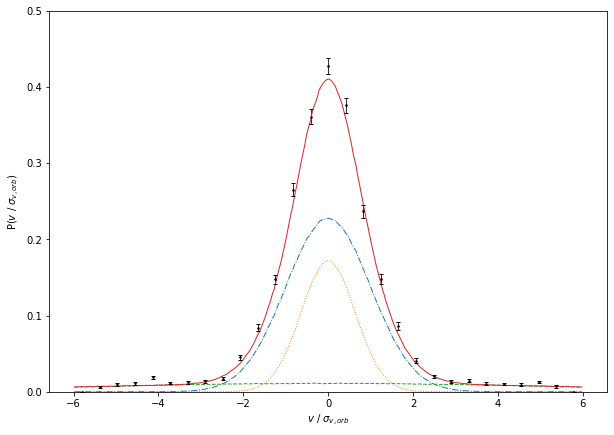

In [40]:
plot_fit(df,origin,0.2,0.4,1000)

In [21]:
m.np_values()

array([-0.52629328, -0.02345397, -0.09864661, -0.10213556, -0.67740921,
        2.04663869,  0.96641595,  0.43527926,  0.46539988,  1.49539176,
        0.34979009, -0.04779524,  3.64042686,  0.46740781, -0.42646046,
        1.78906935,  0.29978946, -0.5183134 ])

In [22]:
nlnlike3(m.np_values())

340737.743149781

The mean value of R_edge is 1.84. (Should be roughly 1.8)
The pivot richness is 32.19. (Should be roughly 32)
The pivot redshift is 0.17. (Should be roughly 0.17)
Maximum normalized velocity 5.65. (Should be roughly 8)


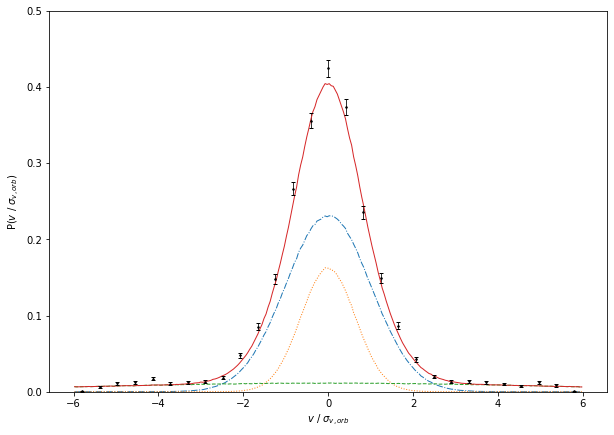

In [23]:
plot_fit(df,m.np_values(),0.2,0.4,1000)

In [24]:
nlnlike3(origin2)

340937.7908688825

The mean value of R_edge is 1.84. (Should be roughly 1.8)
The pivot richness is 32.19. (Should be roughly 32)
The pivot redshift is 0.17. (Should be roughly 0.17)
Maximum normalized velocity 6.91. (Should be roughly 8)


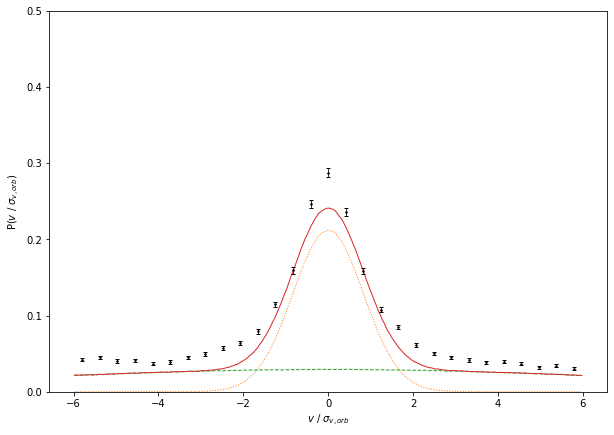

In [25]:
plot_fit(df,origin2,1.0,1.5,1000)

In [26]:
a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, r_p, alpha_r, beta_r=m.values[0],m.values[1],m.values[2],m.values[3],m.values[4],m.values[5],m.values[6],m.values[7],m.values[8],m.values[9],m.values[10],m.values[11],m.values[12],m.values[13],m.values[14],m.values[15],m.values[16],m.values[17]
da1, da2, db1, dc1, dc2, dlnsp_orb, dk, dalpha_orb, dbeta_orb, dlnsp_inf, dalpha_inf, dbeta_inf, dlnsp_los, dalpha_los, dbeta_los, dr_p, dalpha_r, dbeta_r=m.errors[0],m.errors[1],m.errors[2],m.errors[3],m.errors[4],m.errors[5],m.errors[6],m.errors[7],m.errors[8],m.errors[9],m.errors[10],m.errors[11],m.errors[12],m.errors[13],m.errors[14],m.errors[15],m.errors[16],m.errors[17]
print("Minuit model parameters")
print("a1 = %.3f" % a1,u"\u00B1", "%.3f" % da1)
print("a2 = %.3f" % a2,u"\u00B1", "%.3f" % da2)
print("b1 = %.3f" % b1,u"\u00B1", "%.3f" % db1)
print("c1 = %.3f" % c1,u"\u00B1", "%.3f" % dc1)
print("c2 = %.3f" % c2,u"\u00B1", "%.3f" % dc2)
print("sp_orb = %.3f" % np.exp(lnsp_orb),u"\u00B1", "%.3f" % np.multiply(dlnsp_orb,np.exp(lnsp_orb)))
print("sp_inf = %.3f" % np.exp(lnsp_inf),u"\u00B1", "%.3f" % np.multiply(dlnsp_inf,np.exp(lnsp_inf)))
print("sp_los = %.3f" % np.exp(lnsp_los),u"\u00B1", "%.3f" % np.multiply(dlnsp_los,np.exp(lnsp_los)))
print("alpha_orb = %.3f" % alpha_orb,u"\u00B1", "%.3f" % dalpha_orb)
print("alpha_inf = %.3f" % alpha_inf,u"\u00B1", "%.3f" % dalpha_inf)
print("alpha_los = %.3f" % alpha_los,u"\u00B1", "%.3f" % dalpha_los)
print("beta_orb = %.3f" % beta_orb,u"\u00B1", "%.3f" % dbeta_orb)
print("beta_inf = %.3f" % beta_inf,u"\u00B1", "%.3f" % dbeta_orb)
print("beta_los = %.3f" % beta_los,u"\u00B1", "%.3f" % dbeta_los)
print("alpha_r = %.3f" % alpha_r,u"\u00B1", "%.3f" % dalpha_r)
print("beta_r = %.3f" % beta_r,u"\u00B1", "%.3f" % dbeta_r)
print("r_p = %.3f" % r_p,u"\u00B1", "%.3f" % dr_p)

Minuit model parameters
a1 = -0.526 ± 0.045
a2 = -0.023 ± 0.042
b1 = -0.099 ± 0.011
c1 = -0.102 ± 0.146
c2 = -0.677 ± 0.140
sp_orb = 7.742 ± 0.207
sp_inf = 4.461 ± 0.075
sp_los = 38.108 ± 1.540
alpha_orb = 0.435 ± 0.026
alpha_inf = 0.350 ± 0.030
alpha_los = 0.467 ± 0.089
beta_orb = 0.465 ± 0.258
beta_inf = -0.048 ± 0.258
beta_los = -0.426 ± 0.668
alpha_r = 0.300 ± 0.043
beta_r = -0.518 ± 0.415
r_p = 1.789 ± 0.062


For model reconstruction it is convenient to have a burned-in chain to refer to. The following code creates one, using 40 walkers and a chain of length 100. Paxton burned in a chain of length 80,000 for his resampling--I need to leave the computer running for a while to get one like that.

In [27]:
#Parameters that Paxton's mcmc is initialized with
ndim, nwalkers = 18,40
pos = [origin2 + delta2*np.random.randn(ndim) for i in range(nwalkers)]
#Now I set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike3)

In [30]:
sampler.run_mcmc(pos, 100); #run a 1000 length chain starting at pos

In [31]:
#Getting the values that maximize likelihood
flat_chain = np.concatenate(sampler.chain)
flat_lnprobs = np.concatenate(sampler.lnprobability)
max_prob_idx = np.argmax(flat_lnprobs)
max_prob = flat_lnprobs[max_prob_idx]
#p, lnsigma_p, alpha, beta = flat_chain[max_prob_idx]
mcmc_initial=flat_chain[max_prob_idx]

In [32]:
mcmc_initial

array([-0.45777249, -0.06729692, -0.09923561, -0.76623067, -0.10078921,
        2.07219851,  1.03149532,  0.47483282,  0.14936654,  1.52786701,
        0.42005486, -0.60917776,  3.6702692 ,  0.51643471,  0.15376202,
        1.65590604,  0.27748192, -0.8639096 ])

In [33]:
nlnlike3(mcmc_initial)

340773.1240407801

Use Paxton's chains for reconstruction (for now)

In [34]:
def sample_chain(num_draws):
    """
    This function samples from the properly burned
    chain (posterior) to get a Bayesian realization
    num_draws times."""
    chain = np.load("chain_samples.npy")

    draws = np.random.randint(len(chain), size=num_draws) #the indices to draw
    return chain[draws].T #should have dimensions of (NDIM, num_draws) so each row is one variable

In [36]:
def fractions(samples):
    """
    Plotting f_vir and f_bound versus R/Rt.
    Figure 4 in the paper, left pane."""
    a1, a2, b1, c1, c2, lnsp_orb, k, alpha_orb, beta_orb, lnsp_inf, alpha_inf, beta_inf, lnsp_los, alpha_los, beta_los, x_p, alpha_x, beta_x = samples
    b0 = 1 + a1 + a2 #calculated from constraint equations
    c0 = -(c1 + c2) #calculated from constraint equations
    r_by_rt = np.tile(np.linspace(0, X_BY_XT_MAX, 100), (len(samples[0]), 1))

    #assuming all are outside x_p
    f_bound = b0[:,None] + b1[:,None]*(r_by_rt-1)
    f_vir = np.zeros_like(r_by_rt)

    lt_xt = np.where(r_by_rt <= 1)
    lt_xt = np.unique(lt_xt[1])
    #properly reassign those that are actually inside
    f_bound[:,lt_xt] = 1 + a1[:,None]*r_by_rt[:,lt_xt] + a2[:,None]*(r_by_rt[:,lt_xt]**2)
    f_vir[:,lt_xt] = c0[:,None] + c1[:,None]*r_by_rt[:,lt_xt]+ c2[:,None]*(r_by_rt[:,lt_xt]**2)

    bound_means = np.mean(f_bound, axis=0)
    bound_sigmas = np.std(f_bound, axis=0)
    bound_top = bound_means + bound_sigmas
    bound_bottom = bound_means - bound_sigmas

    vir_means = np.mean(f_vir, axis=0)
    vir_sigmas = np.std(f_vir, axis=0)
    vir_top = vir_means + vir_sigmas
    vir_bottom = vir_means - vir_sigmas
    
    bnd = plt.fill_between(r_by_rt[0], bound_top, bound_bottom)
    vir = plt.fill_between(r_by_rt[0], vir_top, vir_bottom)
    plt.legend((bnd, vir), (r"$f_{\rm{da}}$",r"$f_{\rm{orb}}$"))
    plt.ylabel(r"$f_{\rm{orb}},f_{\rm{da}}$")
    plt.ylim(0, 1)
    plt.yticks(np.linspace(0, 1, 6))
    plt.xlabel(r"$R/R_{\rm{edge}}$")
    plt.xlim(0, 2.5)
    plt.xticks(np.linspace(0, 2.5, 6))
    plt.show()

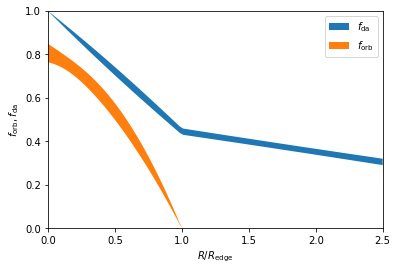

In [37]:
X_BY_XT_MAX = 2.5
samples = sample_chain(2000) #500 for a good band
fractions(samples)